<a href="https://colab.research.google.com/github/DuncanFerguson/GITHUB_REPOSITORY/blob/main/Lab_5_Duncan_Ferguson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5
Student: Duncan Ferguson
<br> Class: COMP-4432-1
<br> Date: 7/28/2022




In [763]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Import Strings
from sklearn.pipeline import Pipeline, _name_estimators
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import operator

import warnings
warnings.filterwarnings('ignore')


# 1. Create a data preprocessing pipeline using scikit-learn

- Combine the data preprocessing and model creation steps from project 1 into a separate pipeline for each of the three algorithms I compared.

- Verify these piplines perform the same as the preprocessing and fitting steps when I executed them individually by making sure the performance metrics on the training and test data match.


## Experiment Objective: 
- Did a client subscribe a term deposit. How do we model this.
- What are the significant factors in determining if a client is subscribed to a term deposit



The Data is being downloaded directly from an archive using !wget from google colab. This will grab the data straight from the source and place it straight on your G-drive. URL below.
<br>https://archive.ics.uci.edu/ml/datasets/bank+marketing



In [695]:
# Grabbing the website
!wget 'banking_data' 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

--2022-07-27 08:32:13--  http://banking_data/
Resolving banking_data (banking_data)... failed: Name or service not known.
wget: unable to resolve host address ‘banking_data’
--2022-07-27 08:32:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip.27’

bank.zip.27         100%[===================>] 565.47K  1.72MB/s    in 0.3s    

2022-07-27 08:32:13 (1.72 MB/s) - ‘bank.zip.27’ saved [579043/579043]

FINISHED --2022-07-27 08:32:13--
Total wall clock time: 0.8s
Downloaded: 1 files, 565K in 0.3s (1.72 MB/s)


In [696]:
# Unzipping the file
!unzip -o 'bank.zip'

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [697]:
# Downloading the Excel file and reading in the second sheet
df = pd.read_csv('bank-full.csv', sep=';')

In [698]:
# Filtering out clients that have been contacted by previous campaigns
df = df.loc[(df['pdays'] == -1) & (df['previous'] == 0)]

# # Dropping out these two columns because they are no longer needed
df = df.drop(labels=['pdays','previous'], axis=1)

# Replacing all the Unknown values with Nan
df.replace('unknown', np.nan, inplace=True)

In [699]:
# Displaying the Head of the Data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,NaN,no


# Project 01 Data Preprocessing
- Below is the data preprocessing that was used. I have left this in so that I can compare it later.

In [700]:
# Displaing the Percentage of missing data per column in decimal form
missing_col_per = pd.DataFrame([(df[col].isnull().sum()/df.shape[0]) for col in df.columns] , df.columns, columns=['Percent_Missing'])
missing_col_per

,Percent_Missing
age,0.000000
job,0.006900
marital,0.000000
education,0.041511
default,0.000000
balance,0.000000
housing,0.000000
loan,0.000000
contact,0.350436
day,0.000000


Since we removed all the clients that had been placed in a campaign before we now get 100% of the Poutcome column as unknown. Meaning that this column can be dropped. Below we set up the threshold for dropping a column as over 80% missing. This will end up taking contact and poutcome out of the equation.

In [701]:
# Setting the limit for dropping
drop_lim = df.shape[0] * .8
df_1 = df.dropna(thresh=drop_lim, axis=1).copy()

In [702]:
# Counting to see how many columns have NaN values
print("# Columns w/ NaN", df_1.isnull().any().sum())
display(df_1.isna().sum())

# Columns w/ NaN 2


age             0
job           255
marital         0
education    1534
default         0
balance         0
housing         0
loan            0
day             0
month           0
duration        0
campaign        0
y               0
dtype: int64

In [703]:
# Imputing the value for the educational missing values
df_2 = df_1.copy()

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer = imputer.fit(df_1.loc[:, df_1.columns == 'education'])
new_education = imputer.transform(df_1.loc[:, df_1.columns == 'education'])

# Replacing education with the newly imputed values
df_2['education'] = new_education.tolist()

In [704]:
df_2 = df_1.dropna()
df_2.isnull().any().sum()

0

Now that the values have been imputed for education. I will just drop the rest  of rows that possess NaN values. These only exist in the job column.

In [705]:
# Simple Drop of NaN rows
df_2 = df_1.dropna()
df_2 = df_2.copy()
print('# Columns w/ Nan')
df_2.isnull().any().sum()

# Columns w/ Nan


0

Note that only two columns had any NaNs those rows have been dealt with we will consider df_2 the main data frame.

There are three different columns that have two classiciations. These are default, housing, loan, and of course Y. We can turn all of theses in to binary. I will also map all the other categorical variables to integer values.

In [706]:
# Cleanding up some values to make coding better
df_2['job'] = df_2['job'].replace(['blue-collar'], 'blue_collar')
df_2['job'] = df_2['job'].replace(['self-employed'], 'self_employed')
df_2['job'] = df_2['job'].replace(['admin.'], 'admin')

In [707]:
df_2.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,no
5,35,management,married,tertiary,no,231,yes,no,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,5,may,217,1,no


Now that I have turned these columns into binary I will cast the objects into categorical variables to help with onehot encoding.

In [708]:
# Casting in to category
obj_cols = [col for col in df_2 if df_2[col].dtype == 'object']
for col in df_2.columns:
  if col in obj_cols:
    df_2[col] = df_2[col].astype('category')

# Changing the binary fields into categories to be used in the models later
df_2['y'] = df_2['y'].astype('category')
df_2['loan'] = df_2['loan'].astype('category')
df_2['default'] = df_2['default'].astype('category')

# Displaying the new data types.
df_2.dtypes

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
day             int64
month        category
duration        int64
campaign        int64
y            category
dtype: object

In [709]:
# Displaying the head of the data
df_2.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,no
5,35,management,married,tertiary,no,231,yes,no,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,5,may,217,1,no


Now setting up a data pipeline to transform the data. Both the objects/categories and the integers. Because I plan on doing a bit of feature selection down the line. I will set up a data pipline within a function that is aimed at preprocessing the data. This way if I performa forward of backward selection model it will be easier to edit through.

It should be noted that df_2 is now primed for Decision Trees or Randomforest.
And the function below is set up to scale the data for algorithms such as KNN and Logistic Regression. By using scaled data it will reduce bias.

Additionally the function below switched the data types for y, loan, default to make sure they dont go through unwanted transformations

In [710]:
def transform_df(df):
  """This Function is set up to make it easy to transform the data if different
   columns are missing"""
  
  # Changing the following to int so they dont get dummies
  # Mapping the respective columns to binary
  df['y'] = df.y.map(dict(yes=1, no=0))
  df['default'] = df.default.map(dict(yes=1, no=0))
  df['loan'] = df.loan.map(dict(yes=1, no=0))

  # Also mapping the different categorical variables
  df['education'] = df.education.map(dict(primary=0, secondary=1, tertiary=2))
  df['housing'] = df.housing.map(dict(no=0, yes=1))
  df['job'] = df.job.map(dict(admin=11, blue_collar=1, entrepreneur=2,
                                housemaid=3, management=4, retired=5,
                                self_employed=6, services=7, student=8,
                                technician=9, unemployed=10))
  df['marital'] = df.marital.map(dict(divorced=0, married=1, single=2))

  df['month'] = df.month.map(dict(jan=1, feb=2,mar=3, apr=4,
                                    may=5, jun=6, jul=7, aug=8, sep=9,
                                    oct=10, nov=11, dec=12))

  df['y'] = df['y'].astype('int64')
  df['loan'] = df['loan'].astype('int64')
  df['default'] = df['default'].astype('int64')

  # Gathering Dummies for the 
  df_t = pd.get_dummies(data=df, columns=[col for col in df if df[col].dtype == 'category'])
  
  # Flipping the y, loan, default back to category so they dont get scaled
  df_t['y'] = df_t['y'].astype('category')
  df_t['loan'] = df_t['loan'].astype('category')
  df_t['default'] = df_t['default'].astype('category')

  
  # Scaling all the integer data with the MinMaxScaler()
  scaler = MinMaxScaler()
  s_cols = [col for col in df_t if df_t[col].dtype == 'int64']
  df_t[s_cols] = scaler.fit_transform(df_t[s_cols])


  return df_t

Note that df_3 is a full feature data set. It is just shown below to display that one hot encoding is actually taking place. and that scalling is being conducted.

This is to display what Project 01 Data Looked Like. df_2 is the data set that I will be using for emulating the pipelines.

Note that I also changed this slighlty from project 1. Now all the transformation happens inside a function. This way I can transform the 

In [711]:
# Displaying what the newly transformed data looks like
df_3 = df_2.copy()
df_3 = transform_df(df_3)

# Pipelining the Preprocessing
- Below is the code used to make a pipeline to preprocess the data

In [712]:
# Displaying the Head of the Data to show that is is un-altered.
df_2.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,no
5,35,management,married,tertiary,no,231,yes,no,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,5,may,217,1,no


In [713]:
# Making a copy of df to be used
df_p = df_2.copy()

# Dropping columns discovered from Project 1
df_p.drop(columns=['day', 'balance',
                   'education', 'default'], inplace=True)

# Changing the Objects to categories
obj_cols = [col for col in df_p if df_p[col].dtype == 'object']
for col in df_p.columns:
  if col in obj_cols:
    df_p[col] = df_p[col].astype('category')

# Dropping the remaining Nan rows
df_p.dropna(inplace=True)

df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35281 entries, 0 to 45209
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       35281 non-null  int64   
 1   job       35281 non-null  category
 2   marital   35281 non-null  category
 3   housing   35281 non-null  category
 4   loan      35281 non-null  category
 5   month     35281 non-null  category
 6   duration  35281 non-null  int64   
 7   campaign  35281 non-null  int64   
 8   y         35281 non-null  category
dtypes: category(6), int64(3)
memory usage: 1.3 MB


This next code block splits df_p into test and training sets.
The Training set is then resampled to have a even distribution.
I should have down sampled the y = no. But I did not do that in project one.
The result gives me a larger test group with a balanced distribution for Y.

In [714]:
# Splitting the data up into X and Y
X_all = df_p.loc[:, df_p.columns != 'y']
Y_all = df_p.loc[:, df_p.columns == 'y']

# Splitting the data up into x and y training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_all, Y_all, test_size=0.2, random_state=42, stratify=Y_all, shuffle=True)

# Putting together the test set to resample
df_train = pd.concat([x_train.reset_index(drop=True),
                        y_train.reset_index(drop=True)], axis=1)

# Diving up the training set to resample
df_maj = df_train[df_train['y'] == 'no']
df_min = df_train[df_train['y'] == 'yes']                        

# Gathering the sample that I want yes to be resampled to
sample_num = len(df_maj)

# Resampling the Yes Responses
min_resampled = resample(df_min, replace=True, n_samples=sample_num, 
                             random_state=42)

# Placing the resampled Training Data set back together
df_resampled = pd.concat([df_maj, min_resampled])

# Splitting the resampled data back up into X and Y
x_train_re = df_resampled.loc[:, df_resampled.columns != 'y']
y_train_re = df_resampled.loc[:, df_resampled.columns == 'y']

In [715]:
df_resampled.head()

,age,job,marital,housing,loan,month,duration,campaign,y
0,26,technician,single,yes,no,jun,209,2,no
2,52,technician,married,no,no,jun,613,1,no
3,48,technician,married,no,no,nov,104,2,no
4,20,student,single,no,no,may,106,2,no
5,53,housemaid,married,yes,no,may,535,1,no


In [716]:
# Creating a pipe Line for the logistic regression
# Setting up the pipeline to transform the numeric Data
numFeatures = df_resampled.select_dtypes(include=['int64']).columns
numTransformer = Pipeline(steps=[('minmax', MinMaxScaler())])

# Setting up the pipeline to transform the Categorical
# This is slightly different from model 1 in the fact that I use onehot over dummies
catFeatures = df_resampled.select_dtypes(include=['category']).drop(['y'], axis=1).columns
catTransformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('Onehot Encoding', OneHotEncoder(drop='if_binary'))])

# Setting up a preprocessor
preprocessor = ColumnTransformer(
                  transformers=[('nums', numTransformer, numFeatures),
                                ('cat', catTransformer, catFeatures)])

# The Logistic Regression Here was Changed to Binomial 
# In project 1 I had it as multinomial which is wrong
logistic_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('Logistic Regression',
                            LogisticRegression(solver='newton-cg'
                              , multi_class='ovr', max_iter = 300))])
logistic_model = logistic_pipeline.fit(x_train_re, y_train_re.values.ravel())

print("The training score was:", round(logistic_model.score(x_train_re, y_train_re)*100,2))
print("The testing score was:", round(logistic_model.score(x_test, y_test)*100,2))

The training score was: 83.01
The testing score was: 83.66


Note that when adjusting project one I ended up with a training score of 79.65 and a testing score of 81.62. This is a slight improvement, I attribut this to using the binary logistic regression and switching dummies to OneHot Endcoding.

The next pipeline is set up for KNN. This is the same set up as the logistic regresion interms of pipeline.

In [717]:
# Setting up the KNN Pipeline
# Note that this requires the same preprocessing as the Logistic Regression

knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                              ('KNN', KNeighborsClassifier(n_neighbors=4))])
knn_model = knn_pipeline.fit(x_train_re, y_train_re.values.ravel())

display("Training score:", round(knn_model.score(x_train_re, y_train_re)*100,2))
display("Testing score:", round(knn_model.score(x_test, y_test)*100,2))

'Training score:'

97.3

'Testing score:'

86.59

Note that this is slighlty different than the Project 1 results
Training Score: 96.88%
Testing Score: 84.67%
I attribute this to the onehot encoding over dummies. The results still give the same trend as project 1. Where this performed slighly better than the Logistic Regression.

The Next Pipeline is for the decision tree. This will be rather simple because I do not need to one hot encode the data or apply dummies to it. 
After doing a bit of spinning of wheels I realized that LabelEncoder does not work inside the pipeline. It is for this reason that I use label encoding outside of the pipeline to try and keep the data set as close to Project 1.


In [718]:
# Decision Tree Pipeline

tree_pipeline = Pipeline(steps=[('Decision Tree', DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=42))])

# Label Encoding the catigorical variables
x_train_re_dt = x_train_re.apply(LabelEncoder().fit_transform)
y_train_re_dt = y_train_re.apply(LabelEncoder().fit_transform)
x_test_re_dt = x_test.apply(LabelEncoder().fit_transform)
y_test_re_dt = y_test.apply(LabelEncoder().fit_transform)

# Fitting the decision tree model
tree_model = tree_pipeline.fit(x_train_re_dt, y_train_re_dt.values.ravel())

# Gathering the scores
display("Training score:", round(tree_model.score(x_train_re_dt, y_train_re_dt)*100,2))
display("Testing score:", round(tree_model.score(x_test_re_dt, y_test_re_dt)*100,2))

'Training score:'

83.01

'Testing score:'

81.85

Compared to Project 1 the training and test scores are slighly different
Training Score: 85.54
Testing Score: 82.17
The results are similiar in range compared to KNN and Logistic Regrestion
Where these resuilts are in the middle and the testing score is slighly lower than the training score.


# 2). Use Nested cross-validation to optimize and compare the performance of the machine learning algorithms you are using to model your data.

- In order to perform a more equal comparison of your models' performance, and to ensure that we have the best set of hyperparameters in use, implement nested cross-validation for each pipeline using the GridSearchCV class and cross_val_score function.

- For each of the pipelines that I am comparing, create a list of values for each applicable hyperparamter and provide it as the param_grid for the GridSearchCV class.

- Compare this nested cross-validation technique to the model comparison I performed in project 1.

- Are my findings different now that the pipelines are tuned and compared in an unbiased manner

Now that we have a transforming method it is time to start looking at if we have equally weight output labels. We do not. Therefore, the next steps are going to be aimed at evening out this training data set. The method that is used is resampling. This is done by over sampling the with replacement until the client respondants with yes is equal to that of those saying no. (1,0)

### Logistic Regression GridSearch and Cross Val Score

In [719]:
# Showing the Different param Keys
logistic_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'Logistic Regression', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__nums', 'preprocessor__cat', 'preprocessor__nums__memory', 'preprocessor__nums__steps', 'preprocessor__nums__verbose', 'preprocessor__nums__minmax', 'preprocessor__nums__minmax__clip', 'preprocessor__nums__minmax__copy', 'preprocessor__nums__minmax__feature_range', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__Onehot Encoding', 'preprocessor__cat__imputer__add_indicator', 'preprocessor__cat__imputer__copy', 'preprocessor__cat__imputer__fill_value', 'preprocessor__cat__imputer__missing_values', 'preprocessor__cat__imputer__strategy', 'preprocessor__cat__imputer__verbose', 'preprocessor__ca

In [724]:
# Logistic Regression Cross-Validation Using GridSearch and score cross_val_Function

# Gathering the Hyperparamaters
lr_parameters = {"Logistic Regression__penalty": ['l2'],
              "Logistic Regression__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              "Logistic Regression__solver": ['newton-cg', 'lbfgs', 'liblinear'],
              "Logistic Regression__max_iter": [100,150,200]}

# Implementing 
lr_grid = GridSearchCV(logistic_pipeline,
                      param_grid = lr_parameters,
                      scoring='accuracy',
                      cv=2)

lr_grid.fit(x_train_re, y_train_re)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nums',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         Index(['age', 'duration', 'campaign'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('Onehot '
                                                                                          'E

In [725]:
# Displaying a List of the Best HyperParamaters for the logistic regression
display("Hyperparameters: ", lr_grid.best_params_)

# Displaing the grid best score
display("Accuracy:" , lr_grid.best_score_)

'Hyperparameters: '

{'Logistic Regression__C': 10.0,
 'Logistic Regression__max_iter': 100,
 'Logistic Regression__penalty': 'l2',
 'Logistic Regression__solver': 'newton-cg'}

'Accuracy:'

0.8319620993527256

When looking at the accuracy score when using the Hyper Oaranaters tge score on the training model improved from .8301 to .8319

In [726]:
# Using the Cros_val_score function
lr_scores = cross_val_score(lr_grid, x_train_re, y_train_re, scoring='accuracy', cv=2)
print('Logistic Regression CV accuracy: %.3f +/- %.3f' % (np.mean(lr_scores),
                                                          np.std(lr_scores)))

Logistic Regression CV accuracy: 0.832 +/- 0.001


- Are my findingds different?

Yes my findings are different. I now have a new C value, I know which penalty to invoke, I also know to lower the amount of max iterations. Thankfully I chose the right solver using newton-cg. 

### KNN GridSearch and Cross Val Score

In [727]:
# Showing the Different param Keys for the KNN Pipeline
knn_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'KNN', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__nums', 'preprocessor__cat', 'preprocessor__nums__memory', 'preprocessor__nums__steps', 'preprocessor__nums__verbose', 'preprocessor__nums__minmax', 'preprocessor__nums__minmax__clip', 'preprocessor__nums__minmax__copy', 'preprocessor__nums__minmax__feature_range', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__Onehot Encoding', 'preprocessor__cat__imputer__add_indicator', 'preprocessor__cat__imputer__copy', 'preprocessor__cat__imputer__fill_value', 'preprocessor__cat__imputer__missing_values', 'preprocessor__cat__imputer__strategy', 'preprocessor__cat__imputer__verbose', 'preprocessor__cat__Onehot Encodi

In [732]:
# KNN Cross-Validation Using GridSearch and score cross_val_Function

# # Gathering the Hyperparamaters
# Note the commented out code below would be nice to see, but it was taking too long
# knn_parameters = {"KNN__n_neighbors": [1,2,4,6,8,10,None],
#                   "KNN__metric":['euclidean','manhattan'],
#                   "KNN__weights":['uniform','distance']}

knn_parameters = {"KNN__n_neighbors": [1,2,4,6,None],
                  "KNN__weights":['uniform','distance']}                  

knn_parameters = {"KNN__n_neighbors": [1,2,4,6,None]}  

# Implementing the grid search
knn_grid = GridSearchCV(knn_pipeline,
                        param_grid = knn_parameters,
                        scoring='accuracy',
                        cv=2,
                        verbose=10)

knn_grid.fit(x_train_re, y_train_re)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START KNN__n_neighbors=1, KNN__weights=uniform...................
[CV 1/2; 1/10] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.952 total time=  21.1s
[CV 2/2; 1/10] START KNN__n_neighbors=1, KNN__weights=uniform...................
[CV 2/2; 1/10] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.952 total time=  17.4s
[CV 1/2; 2/10] START KNN__n_neighbors=1, KNN__weights=distance..................
[CV 1/2; 2/10] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.952 total time=  16.6s
[CV 2/2; 2/10] START KNN__n_neighbors=1, KNN__weights=distance..................
[CV 2/2; 2/10] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.952 total time=  16.9s
[CV 1/2; 3/10] START KNN__n_neighbors=2, KNN__weights=uniform...................
[CV 1/2; 3/10] END KNN__n_neighbors=2, KNN__weights=uniform;, score=0.945 total time=  18.5s
[CV 2/2; 3/10] START KNN__n_neighbors=2, KNN__weights=uniform......

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nums',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         Index(['age', 'duration', 'campaign'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('Onehot '
                                                                                          'E

In [733]:
# Displaying a List of the Best HyperParamaters for KNN
display("Hyperparameters: ", knn_grid.best_params_)

# Displaing the grid best score
display("Accuracy:" , knn_grid.best_score_)

'Hyperparameters: '

{'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}

'Accuracy:'

0.9522732589877564

In [734]:
# Using the Cros_val_score function
knn_scores = cross_val_score(knn_grid, x_train_re, y_train_re, scoring='accuracy', cv=2)
print('Logistic Regression CV accuracy: %.3f +/- %.3f' % (np.mean(knn_scores),
                                                          np.std(knn_scores)))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START KNN__n_neighbors=1, KNN__weights=uniform...................
[CV 1/2; 1/10] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.914 total time=   6.9s
[CV 2/2; 1/10] START KNN__n_neighbors=1, KNN__weights=uniform...................
[CV 2/2; 1/10] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.917 total time=   5.1s
[CV 1/2; 2/10] START KNN__n_neighbors=1, KNN__weights=distance..................
[CV 1/2; 2/10] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.914 total time=   4.2s
[CV 2/2; 2/10] START KNN__n_neighbors=1, KNN__weights=distance..................
[CV 2/2; 2/10] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.917 total time=   4.1s
[CV 1/2; 3/10] START KNN__n_neighbors=2, KNN__weights=uniform...................
[CV 1/2; 3/10] END KNN__n_neighbors=2, KNN__weights=uniform;, score=0.873 total time=   4.8s
[CV 2/2; 3/10] START KNN__n_neighbors=2, KNN__weights=uniform......

- Are my findings different?

Yes my findings are different. I now know to use uniform weights and set the n neighbors to 1. Though, some how the powel performed worse than the model than the model that was used 

### Decision Tree GridSearch and Cross Val Score

In [736]:
# Showing the differen param keys for the Decision Tree Pipeline
tree_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Decision Tree', 'Decision Tree__ccp_alpha', 'Decision Tree__class_weight', 'Decision Tree__criterion', 'Decision Tree__max_depth', 'Decision Tree__max_features', 'Decision Tree__max_leaf_nodes', 'Decision Tree__min_impurity_decrease', 'Decision Tree__min_samples_leaf', 'Decision Tree__min_samples_split', 'Decision Tree__min_weight_fraction_leaf', 'Decision Tree__random_state', 'Decision Tree__splitter'])

In [738]:
# Decision Tree Cross-Validation Using GridSearch and score cross_val_function

# Declaring the Decision Tree Paramaters
tree_parameters = {'Decision Tree__max_depth':  [1, 4, 5, 6, None],
                   'Decision Tree__criterion': ['gini', 'entropy'] }

# Implementing the Decision Tree GridSearch
tree_grid = GridSearchCV(estimator=tree_pipeline,
                         param_grid=tree_parameters,
                         scoring='accuracy',
                         cv=2)

tree_grid.fit(x_train_re_dt, y_train_re_dt)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('Decision Tree',
                                        DecisionTreeClassifier(max_depth=6,
                                                               random_state=42))]),
             param_grid={'Decision Tree__criterion': ['gini', 'entropy'],
                         'Decision Tree__max_depth': [1, 4, 5, 6, None]},
             scoring='accuracy')

In [739]:
# Displaying a List of the Best HyperParamaters for KNN
display("Hyperparameters: ", tree_grid.best_params_)

# Displaing the grid best score
display("Accuracy:" , tree_grid.best_score_)

'Hyperparameters: '

{'Decision Tree__criterion': 'gini', 'Decision Tree__max_depth': None}

'Accuracy:'

0.9518248459798799

In [740]:
# Using the Cros_val_score function
tree_scores = cross_val_score(tree_grid, x_train_re_dt, y_train_re_dt, scoring='accuracy', cv=2)
print('Logistic Regression CV accuracy: %.3f +/- %.3f' % (np.mean(tree_scores),
                                                          np.std(tree_scores)))

Logistic Regression CV accuracy: 0.951 +/- 0.000


- Are my findings different?

YEs the findings are a bit different. The best tree depth was none which is interest. The Accuracy Score increded dramatically. Thankfully gini was the critiron that was suggested.

# 3). Create a confusion matrix

- Create a confusion matrix showing the TP, FP, TN, and FN values for each of the three optimized pipelines that were created using nested cross validation in step 2.

- Visualize the confusion matrix using a similar technique to the one that was used in the ch06 example

## Model 1: Logistic Regression

In [741]:
# # Model Code 1: Logistic Regression
# logistic_eval = Pipeline(steps=[('classifier', LogisticRegression(solver='newton-cg', multi_class='ovr'))])
# logistic_eval.fit(x_train_re, y_train_re.values.ravel())

# Printing the accuracy of the test
display("Training score:", round(lr_grid.score(x_train_re, y_train_re)*100,2))
display("Testing score:", round(lr_grid.score(x_test, y_test)*100,2))

'Training score:'

83.1

'Testing score:'

83.62

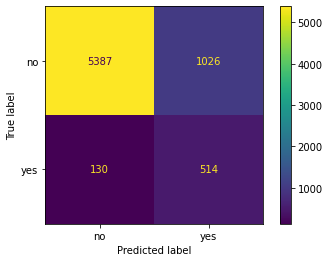

In [743]:
#  Creating Predictions for the logistic regression
y_logistic_pred = lr_grid.predict(x_test)

# Creating a confusion matrix to look at different Scores
conf_matrix_log = confusion_matrix(y_test, y_logistic_pred)

# Displaying the Confusion Matrix
log_labels = ['no','yes']
ConfusionMatrixDisplay(conf_matrix_log, display_labels=log_labels).plot()
plt.show()

In [746]:
# Computing the precision, recall, and f1 scores for the Logistic Regresion
display("Precision Score: ", precision_score(y_true=y_test, y_pred=y_logistic_pred))
display("Recall Score: ", recall_score(y_true=y_test, y_pred=y_logistic_pred))
display("F1 Score:", f1_score(y_true=y_test, y_pred=y_logistic_pred))

ValueError: ignored

## Model 2: K-Nearest Neighbour

To start the K-Nearest Neighbour I will use K means to determine where the elbow is to figure out how many clusters I want to use. It is a bit crude, but better than just guessing.

In [744]:
# Model Code 2: K-Nearest Neighbour

# Printing the accuracy of the test
display("Training score:", round(knn_grid.score(x_train_re, y_train_re)*100,2))
display("Testing score:", round(knn_grid.score(x_test, y_test)*100,2))

'Training score:'

99.92

'Testing score:'

88.83

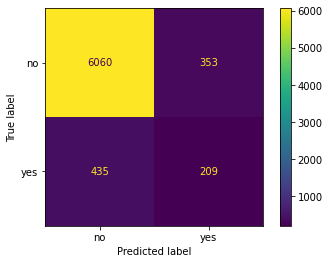

In [745]:
#  Creating Predictions for the logistic regression
y_knn_pred = knn_grid.predict(x_test)

# Creating a confusion matrix to look at different Scores
conf_matrix_knn = confusion_matrix(y_test, y_knn_pred)

# Displaying the Confusion Matrix
log_labels = ['no','yes']
ConfusionMatrixDisplay(conf_matrix_knn, display_labels=log_labels).plot()
plt.show()

In [756]:
# Computing the precision, recall, and f1 scores for the KNN
# display("Precision Score: ", precision_score(y_true=y_test_, y_pred=y_knn_pred))
# display("Recall Score: ", recall_score(y_true=y_test_re_dt, y_pred=y_knn_pred))
# display("F1 Score:", f1_score(y_true=y_test_re_dt, y_pred=y_knn_pred))

NameError: ignored

## Model 3: Decision Tree

It must be noted that for the decision tree I use the same training and testing that the random rain forrest did above. The reason for this was to not enclude scaling or one hot encoding. 

In [749]:
# Model Code 3: Decision Tree

# Printing the accuracy of the test
display("Training score:", round(tree_model.score(x_train_re_dt, y_train_re_dt)*100,2))
# display("Testing score:", round(tree_model.score(x_test_dt, y_test_dt)*100,2))

'Training score:'

83.01

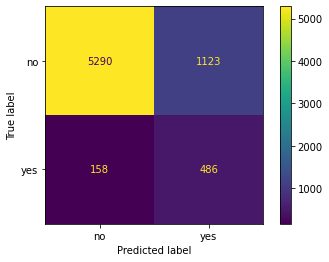

In [751]:
#  Creating Predictions for the logistic regression
y_tree_pred = tree_model.predict(x_test_re_dt)

# Creating a confusion matrix to look at different Scores
conf_matrix_tree = confusion_matrix(y_test_re_dt, y_tree_pred)

# Displaying the Confusion Matrix
log_labels = ['no','yes']
ConfusionMatrixDisplay(conf_matrix_tree, display_labels=log_labels).plot()
plt.show()

In [752]:
# Computing the precision, recall, and f1 scores for the Decision Tree
display("Precision Score: ", precision_score(y_true=y_test_re_dt, y_pred=y_tree_pred))
display("Recall Score: ", recall_score(y_true=y_test_re_dt, y_pred=y_tree_pred))
display("F1 Score:", f1_score(y_true=y_test_re_dt, y_pred=y_tree_pred))

'Precision Score: '

0.30205096333126163

'Recall Score: '

0.7546583850931677

'F1 Score:'

0.4314247669773635

# 4). Creat a MajorityVoteClassifer instance from the algorithms I've chosen to see if an ensemble can outperform the individual algorithms

- Now that we better understand how each of the models perform individually, let's creat an ensemble to see if they work better together

- Using the MajorityVoteClassifier class that was created in the ch07 example Juypter Note book, create an ensemble using the three pipelines I created in step 1.

- Use 10-fold cross validation to compute the score of the ensemble, as well as each pipeline individually.

- Compare the performance of the ensemble to the individual models

- Does the ensemble outperform the models?

- Note: While we used ROC AUC scores in class, that was for binary classification only. Thankfully that is the classification that was used.

In [764]:
# The code below is from ch07 example
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

- Below I use the MajoritVoteClassifier to create an ensemble using the Logistic Regression, KNN and a Decision Tree

In [765]:
# Creating my clf labels
clf_labels = ['Logistic regression', 'KNN', 'Decision tree']

- Below computes the score of the ensemble using 10-fold cross-validation


In [768]:
mv_clf = MajorityVoteClassifier(classifiers=[logistic_pipeline, knn_pipeline, tree_pipeline])

clf_labels += ['Majority voting']
all_clf = [logistic_pipeline, knn_pipeline, tree_pipeline, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=x_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc',
                             verbose=True)
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ROC AUC: 0.90 (+/- 0.01) [Logistic regression]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ROC AUC: 0.76 (+/- 0.02) [KNN]
ROC AUC: nan (+/- nan) [Decision tree]
ROC AUC: nan (+/- nan) [Majority voting]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


- Below uses the ensemble to sore each Pipeline is also each individually

In [770]:
# Scoring all of the models indi
display('10-fold cross validation')

for clf, label in zip([logistic_pipeline, knn_pipeline, tree_pipeline], clf_labels):
  scores = cross_val_score(estimator=clf,
                            X=x_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc',
                            verbose=True)
  print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

'10-fold cross validation'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ROC AUC: 0.90 (+/- 0.01) [Logistic regression]
ROC AUC: 0.76 (+/- 0.02) [KNN]
ROC AUC: nan (+/- nan) [Decision tree]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


- Below evaluates and tunes the ensemble classifier

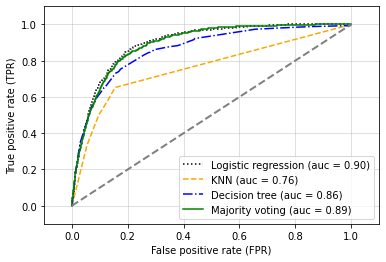

In [776]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(x_train_re_dt, y_train_re_dt).predict_proba(x_test_re_dt)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test_re_dt,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

- Does the ensemble outperform the models? (Using ROC AUC score)

No, at the moment the ensemble does not outperform the other models. Right now it looks like the logistic regression is the most accurate Model
